In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pyro.optim import Adam
from sklearn.metrics import silhouette_score, roc_curve, roc_auc_score
from statsmodels.graphics.gofplots import qqplot
from dotenv import load_dotenv
import os
import mysql.connector
from skopt import BayesSearchCV
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, gaussian_kde

%matplotlib inline

# Set font for plots
plt.rcParams['font.family'] = 'Arial'

# Filter out RuntimeWarnings
warnings.filterwarnings("ignore")


C:\Users\Owais\anaconda3\envs\mental_health_exp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load environment variables from the .env file for security
load_dotenv()

# Get database connection details from env variables
user = os.environ.get('DB_USER')
password = os.environ.get('DB_PASSWORD')
host = os.environ.get('DB_HOST')
database = os.environ.get('DB_DATABASE')

# Establish a MySQL connection
connection = mysql.connector.connect(
    user=user,
    password=password,
    host=host,
    database=database
)


```MySQL
-- Create database
CREATE DATABASE IF NOT EXISTS test;
USE test;

-- Assuming 'Student_Stress' table already exists

-- Drop the 'Balanced_Lifestyle' column from 'Student_Stress' table
ALTER TABLE Student_Stress
DROP COLUMN Balanced_Lifestyle;

-- Create a new table 'Student_Stress_Altered' with the desired changes
CREATE TABLE IF NOT EXISTS Student_Stress_Altered AS
SELECT
    *,
    CAST(NULL AS FLOAT) AS Performance_to_Load_Ratio,
    CAST(NULL AS FLOAT) AS High_sports_Low_Sleep,
    CAST(NULL AS FLOAT) AS Overall_Burden,
    CAST(NULL AS FLOAT) AS Balanced_Lifestyle
FROM Student_Stress;

-- Update columns in 'Student_Stress_Altered' table
UPDATE Student_Stress_Altered
SET
    Performance_to_Load_Ratio = NULLIF(Study_Load_Hours / NULLIF(Academic_Performance_Score, 0), 0),
    High_sports_Low_Sleep = NULLIF(Extracurricular_Frequency / NULLIF(Sleep_Quality, 0), 0),
    Overall_Burden = NULLIF(Study_Load_Hours + Extracurricular_Frequency + Frequency_of_Headaches, 0),
    Balanced_Lifestyle = NULLIF(Sleep_Quality + 0.5 * Extracurricular_Frequency - 0.2 * Frequency_of_Headaches, 0);

-- Categorize headaches
UPDATE Student_Stress_Altered
SET Frequency_of_Headaches =
    CASE
        WHEN Frequency_of_Headaches < 2 THEN 'rare'
        WHEN Frequency_of_Headaches <= 3 THEN 'common'
        ELSE 'frequent'
    END;

-- Categorize sleep quality
UPDATE Student_Stress_Altered
SET Sleep_Quality =
    CASE
        WHEN Sleep_Quality <= 2 THEN 'poor'
        WHEN Sleep_Quality <= 4 THEN 'average'
        ELSE 'excellent'
    END;

-- Categorize extracurricular activity
UPDATE Student_Stress_Altered
SET Extracurricular_Frequency =
    CASE
        WHEN Extracurricular_Frequency <= 2 THEN 'low'
        WHEN Extracurricular_Frequency <= 4 THEN 'moderate'
        ELSE 'high'
    END;

-- Categorize stress level
UPDATE Student_Stress_Altered
SET Stress_Level =
    CASE
        WHEN Stress_Level <= 2 THEN 'low'
        WHEN Stress_Level <= 4 THEN 'moderate'
       ``` ELSE 'high'
    END;

-- Clean up
SET SQL_SAFE_UPDATES = 0;


# Feature Engineering
1. **Performance-to-Load Ratio:**

$$\\ Formula: \text{{Performance\_to\_Load\_Ratio}} = \frac{{\text{{Study\_Load\_Hours}}}}{{\text{{Academic\_Performance\_Score}}}}\  \\ $$

This ratio measures the relationship between study load hours and academic performance. A higher ratio may suggest that the student is achieving better academic performance with less study load, lowering stress.

2. **High_sports_Low_Sleep:**

$$\\ Formula: \text{{High\_sports\_Low\_Sleep}} = \frac{{\text{{Extracurricular\_Frequency}}}}{{\text{{Sleep\_Quality}}}}\  \\ $$

This ratio indicates the balance between involvement in extracurricular activities and the quality of sleep. A higher ratio may suggest that the student is highly involved in extracurricular activities while maintaining good sleep quality, lowering stress.

3. **Overall_Burden:**

$$\\ Formula: \text{{Overall\_Burden}} = \text{{Sleep\_Quality}} + \text{{Extracurricular\_Frequency}} +\text{{Frequency\_of\_Headaches}}   \\ $$

This metric combines study load hours, extracurricular activity frequency, and headache frequency. It provides an overall measure of the student's academic and extracurricular workload and the frequency of headaches, which could potentially increase stress.

4. **Balanced Lifestyle:**

$$\\ Formula: \text{{Balanced\_Lifestyle}} = \text{{Sleep\_Quality}} + 0.5  \times  \text{{Extracurricular\_Frequency}} - 0.2  \times \text{{Frequency\_of\_Headaches}}   \\ $$

This metric attempts to quantify the balance in the student's lifestyle by considering sleep quality, extracurricular activity frequency, and the impact of headaches. It aims to capture a balanced lifestyle, considering both positive and negative factors. Leading to a low or average stress level.

In [3]:
#SQL Query
query = 'SELECT * FROM  Student_Stress'

# Load data into a Pandas DataFrame
df = pd.read_sql(query, con=connection)

In [4]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
display(df.head())

# Check for missing values
print("\nMissing values:")
display(df.isnull().sum())

# Summary statistics
print("\nSummary statistics:")
display(df.describe())

First few rows of the dataset:


,Kindly Rate your Sleep Quality,How many times a week do you suffer headaches?,How would you rate you academic performance?,how would you rate your study load?,How many times a week you practice extracurricular activities?,How would you rate your stress levels?
0,3,1,3,4,2,3
1,4,1,2,3,3,2
2,2,1,2,1,4,4
3,3,2,3,2,3,3
4,2,3,1,5,5,3



Missing values:


Kindly Rate your Sleep Quality                                    0
How many times a week do you suffer headaches?                    0
How would you rate you academic performance?                      0
how would you rate your study load?                               0
How many times a week you practice extracurricular activities?    0
How would you rate your stress levels?                            0
dtype: int64


Summary statistics:


,Kindly Rate your Sleep Quality,How many times a week do you suffer headaches?,How would you rate you academic performance?,how would you rate your study load?,How many times a week you practice extracurricular activities?,How would you rate your stress levels?
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,3.125000,2.182692,3.326923,2.750000,2.682692,2.875000
std,1.099023,1.247459,1.061158,1.372381,1.470745,1.357825
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000
50%,3.000000,2.000000,3.000000,2.500000,3.000000,3.000000
75%,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


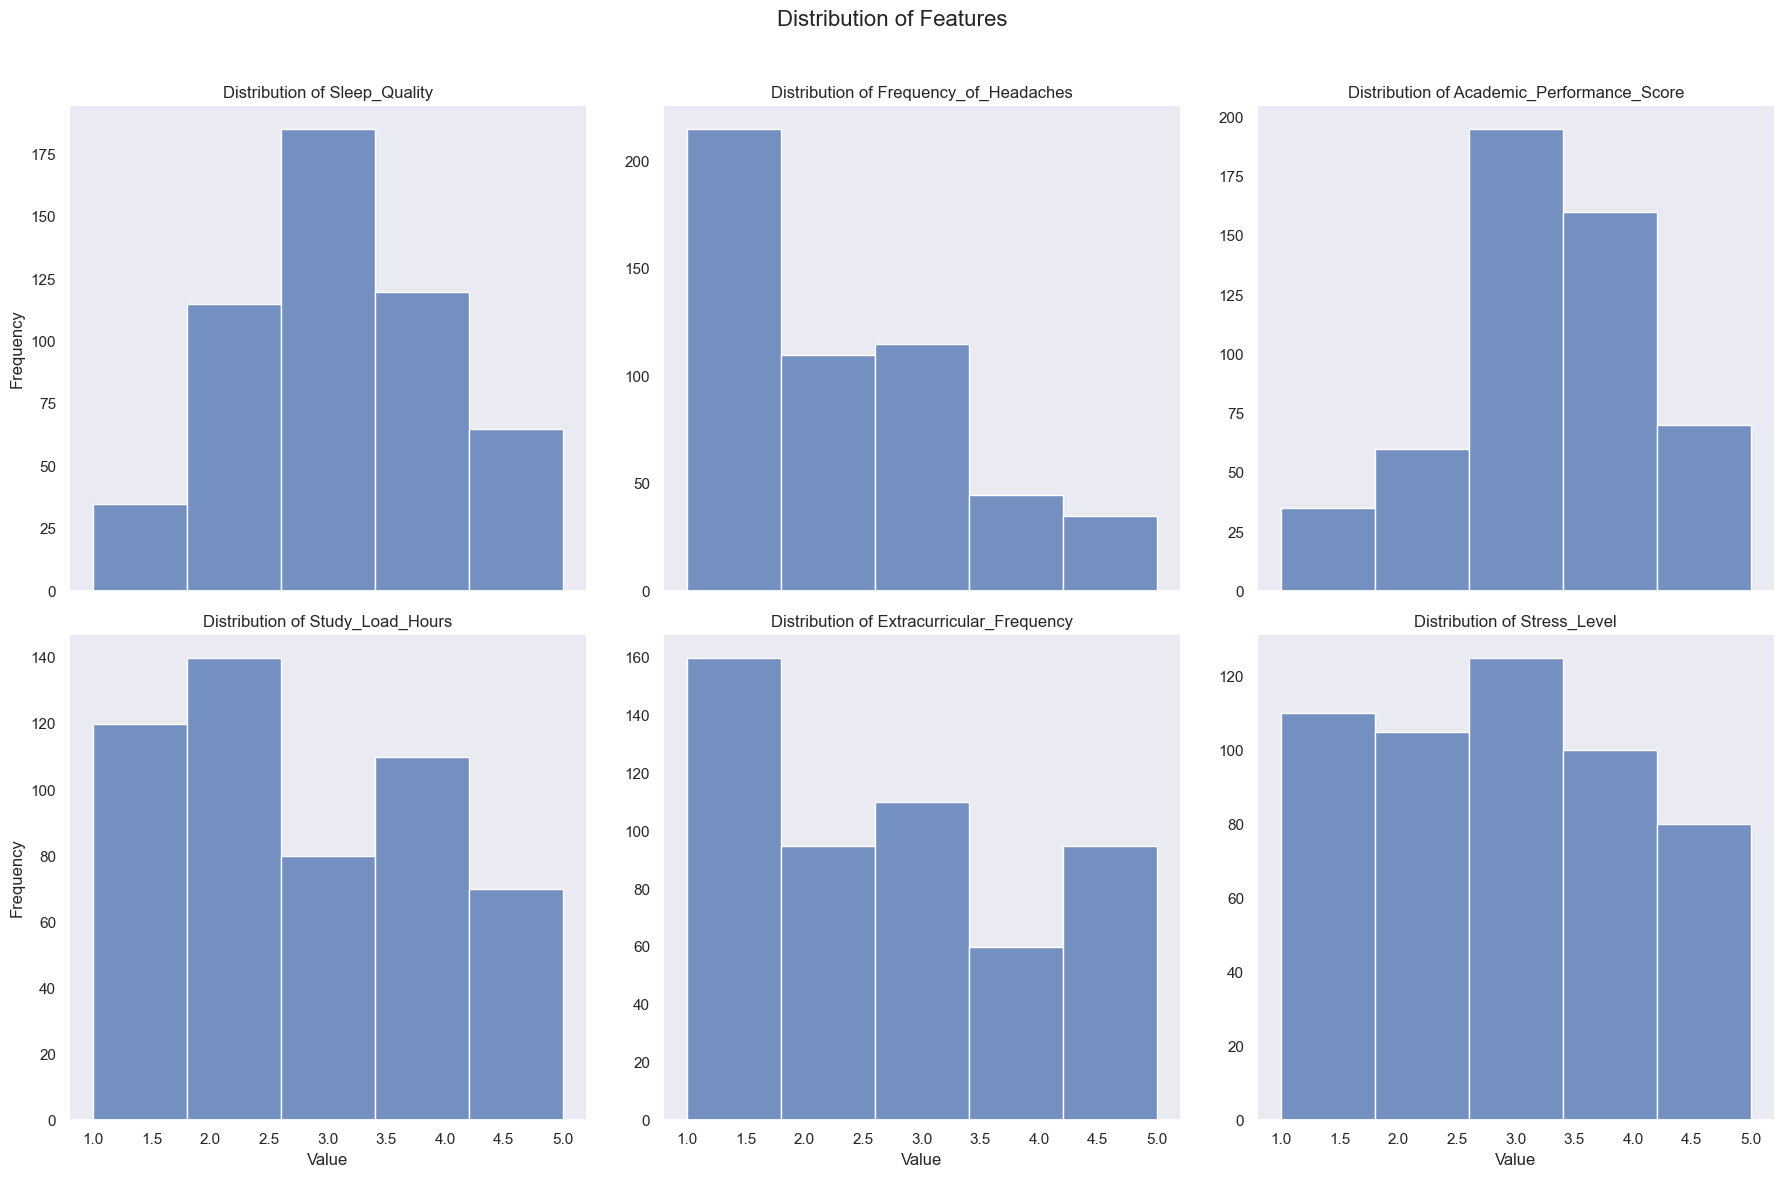

In [5]:
# Rename the columns for ease of use
df.columns = ['Sleep_Quality', 'Frequency_of_Headaches', 'Academic_Performance_Score', 'Study_Load_Hours', 'Extracurricular_Frequency', 'Stress_Level']

# Set the Seaborn style
sns.set(style="dark")

# Create subplots using Seaborn's FacetGrid
g = sns.FacetGrid(df.melt(), col_wrap=3, col="variable", height=6, sharey=False)

# Map histograms onto the grid
g.map(sns.histplot, "value", bins=5)

# Adjust layout to prevent overlap of titles
g.set_titles("Distribution of {col_name}", size=12)
g.set_axis_labels("Value", "Frequency")

# Customise the overall title
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of Features", size=16)

plt.show()


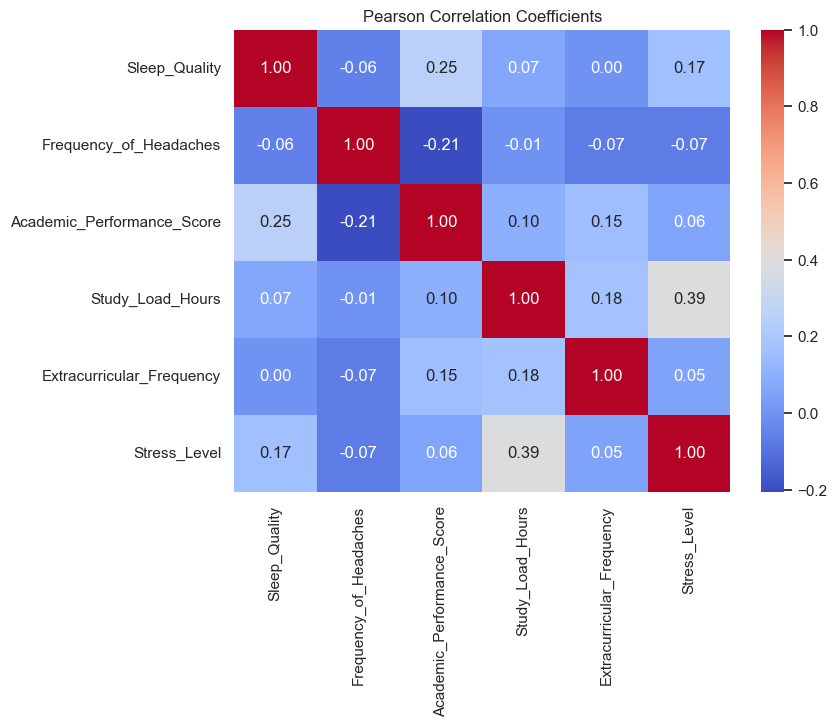

In [6]:
# Create a heatmap of Pearson correlation coefficients
corr_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Coefficients')
plt.show()

In [7]:
#Collect only Features
df_features = df.iloc[:, :-1]

# Convert DataFrame to NumPy array
features_array = df_features.to_numpy(dtype=np.float32)

# Load features and labels into PyTorch tensors
features_tensor = torch.tensor(features_array, dtype=torch.float32)
stress_labels_tensor = torch.tensor(df['Stress_Level'].to_numpy(), dtype=torch.float32)  # Assuming stress levels are continuous

# Create a PyTorch dataset and DataLoader
dataset = TensorDataset(features_tensor, stress_labels_tensor)
batch_size = 32  # Set your desired batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_tensor, stress_labels_tensor, test_size=0.2, random_state=42)

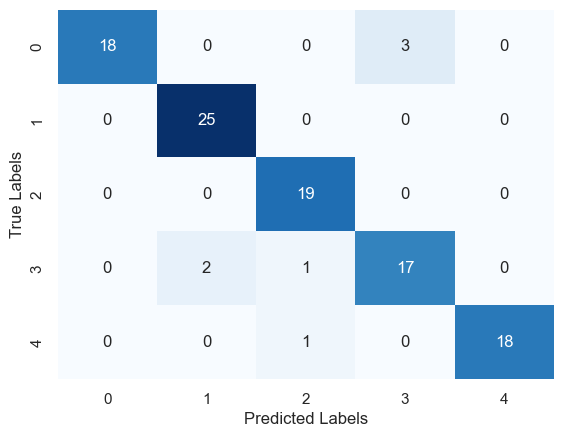

Sorted Feature Importance:
                      Feature  Importance
3            Study_Load_Hours    0.220023
2  Academic_Performance_Score    0.214895
4   Extracurricular_Frequency    0.194876
0               Sleep_Quality    0.190589
1      Frequency_of_Headaches    0.179617
Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      0.86      0.92        21
         2.0       0.93      1.00      0.96        25
         3.0       0.90      1.00      0.95        19
         4.0       0.85      0.85      0.85        20
         5.0       1.00      0.95      0.97        19

    accuracy                           0.93       104
   macro avg       0.94      0.93      0.93       104
weighted avg       0.94      0.93      0.93       104



In [8]:
# Define the Random Forest model with the best parameters
#(Taken from bayes optimisation later on)
rf_model = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=300)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Convert the PyTorch tensor X_train back to a pandas DataFrame
X_train_df = pd.DataFrame(X_train.numpy(), columns=df.columns[:-1])

# Get feature importance from the trained model
feature_importance = rf_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train_df.columns,
    'Importance': feature_importance
})

# Sort the DataFrame by importance to identify features associated with higher stress levels
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

# Generate predictions on the test set
y_pred = rf_model.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualise confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Display the sorted feature importance DataFrame
print("Sorted Feature Importance:")
print(feature_importance_df_sorted)

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

In [9]:
#Query to the old database and add the engineering features, this is done for data visualisation
query = 'SELECT * FROM Student_Stress_Altered'

# Load data into a Pandas DataFrame
df_query = pd.read_sql(query, con=connection)

# Extract the last four columns from the loaded DataFrame
last_four_columns = df_query.iloc[:, -4:]

# # Add the last four columns to your own DataFrame
df = pd.concat([df, last_four_columns], axis=1)

df

,Sleep_Quality,Frequency_of_Headaches,Academic_Performance_Score,Study_Load_Hours,Extracurricular_Frequency,Stress_Level,Performance_to_Load_Ratio,High_sports_Low_Sleep,Overall_Burden,Balanced_Lifestyle
0,3,1,3,4,2,3,1.3333333333333333,0.666667,7.0,3.8
1,4,1,2,3,3,2,1.5,0.750000,7.0,5.3
2,2,1,2,1,4,4,0.5,2.000000,6.0,3.8
3,3,2,3,2,3,3,0.6666666666666666,1.000000,7.0,4.1
4,2,3,1,5,5,3,5,2.500000,13.0,3.9
...,...,...,...,...,...,...,...,...,...,...
515,3,2,4,2,3,1,0.5,1.000000,7.0,4.1
516,2,4,3,2,1,2,0.6666666666666666,0.500000,7.0,1.7
517,2,3,5,1,5,2,0.2,2.500000,9.0,3.9
518,3,4,3,5,2,5,1.6666666666666667,0.666667,11.0,3.2


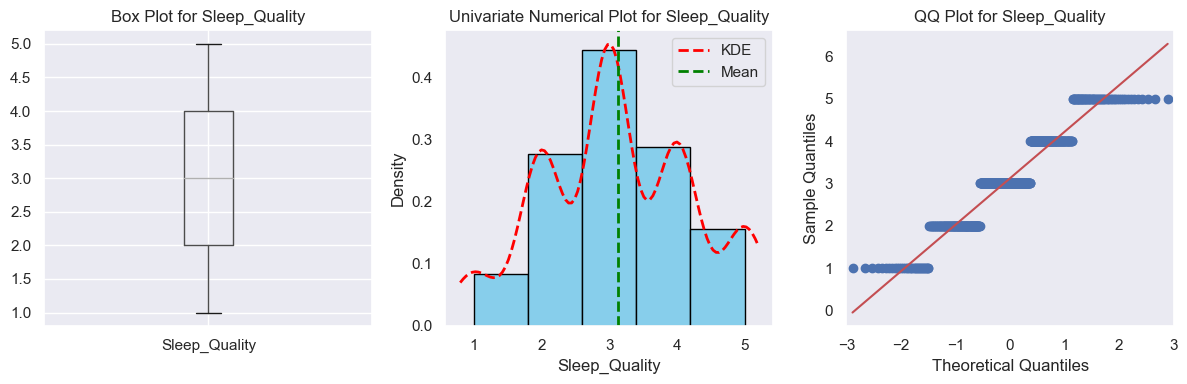

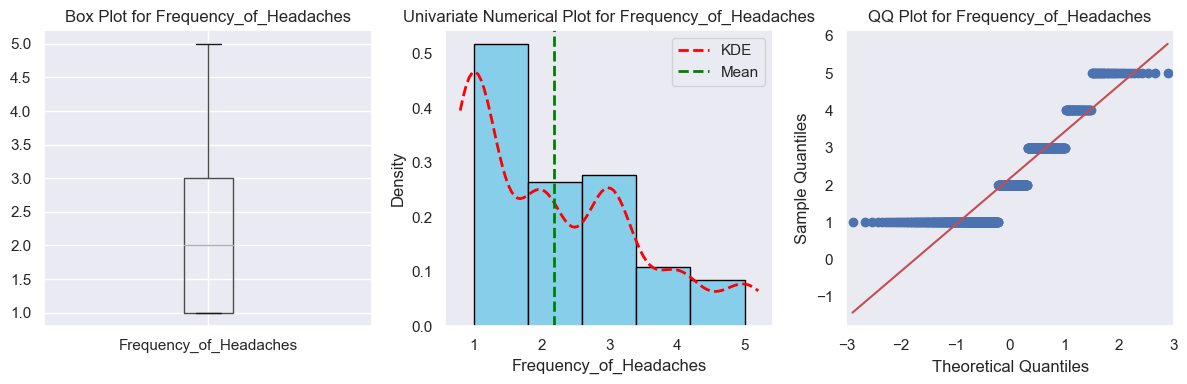

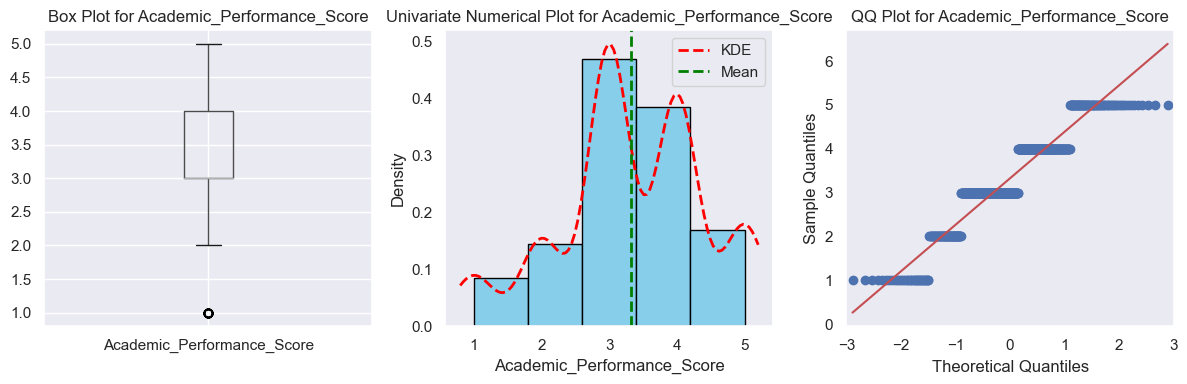

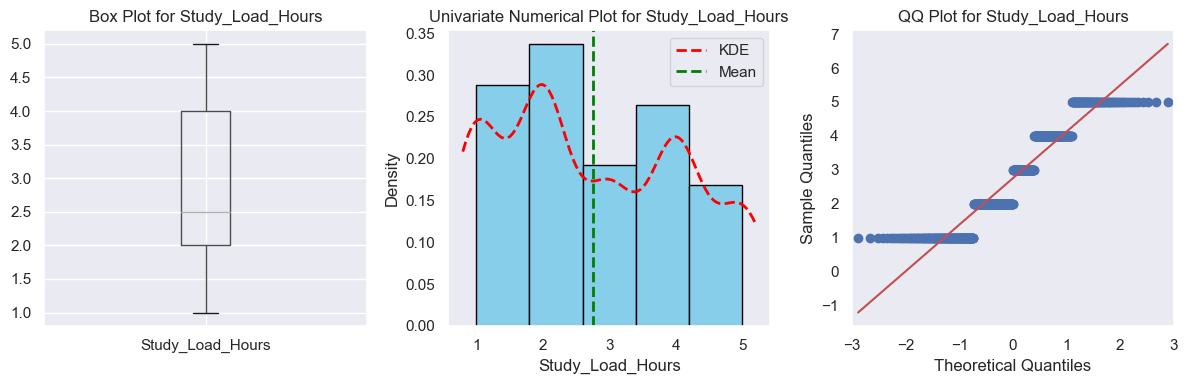

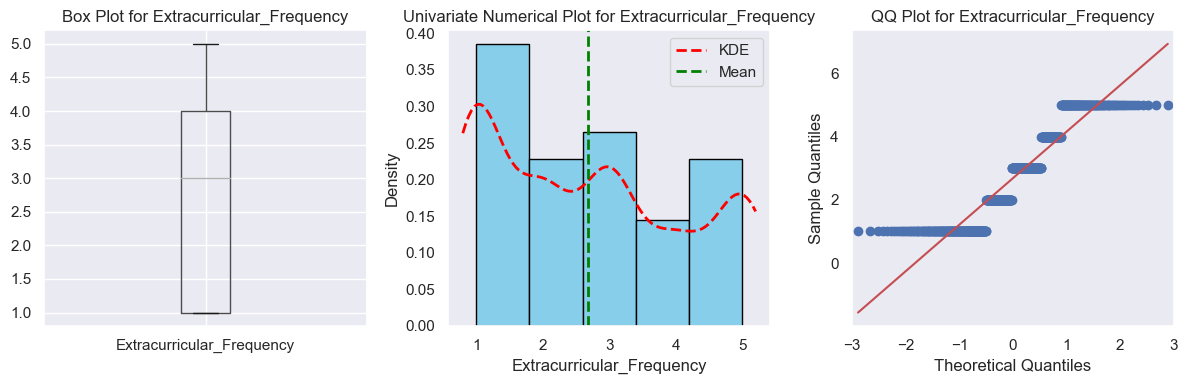

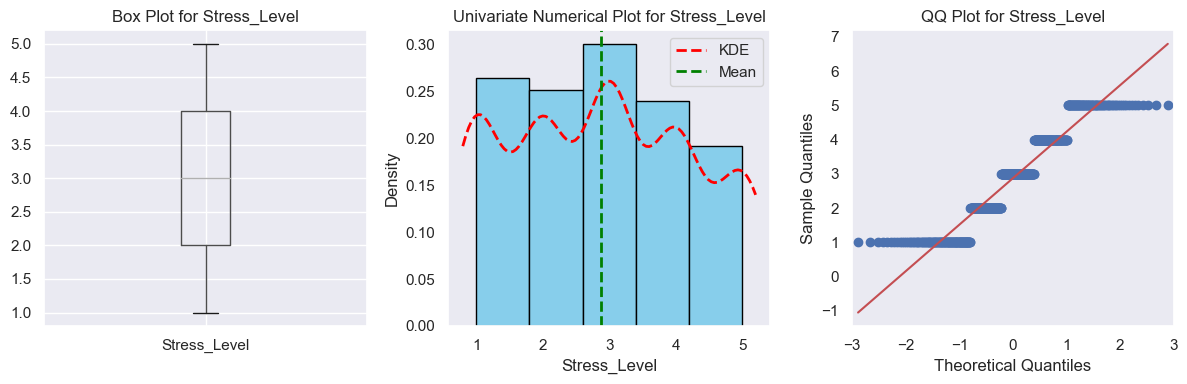

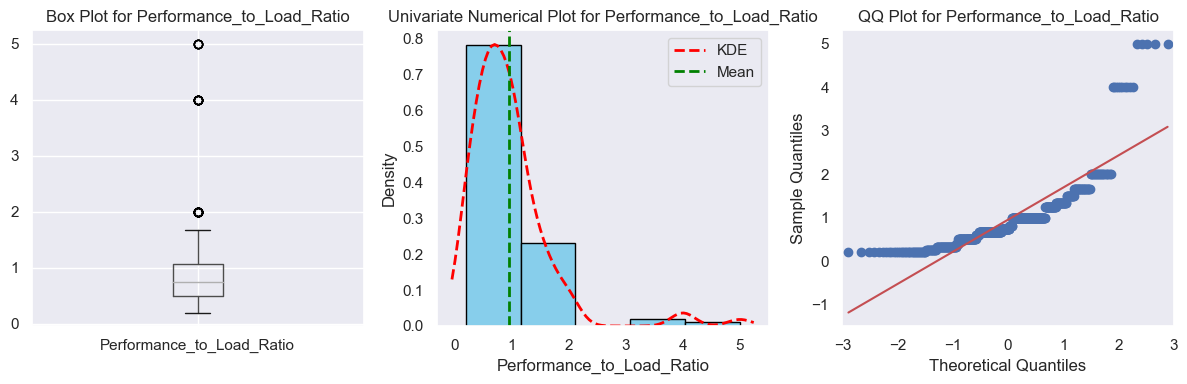

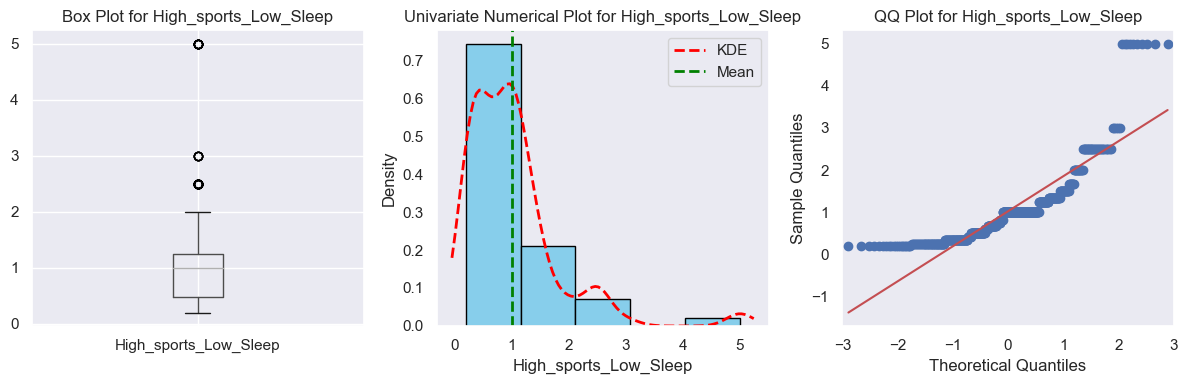

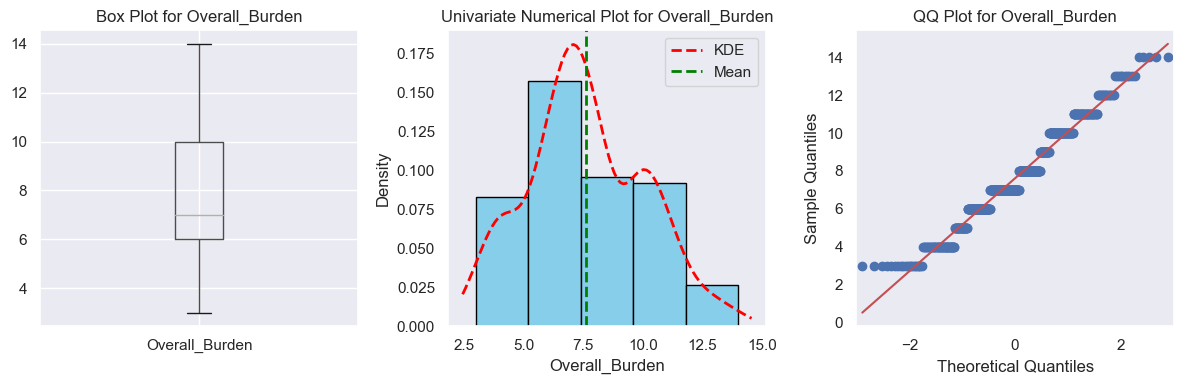

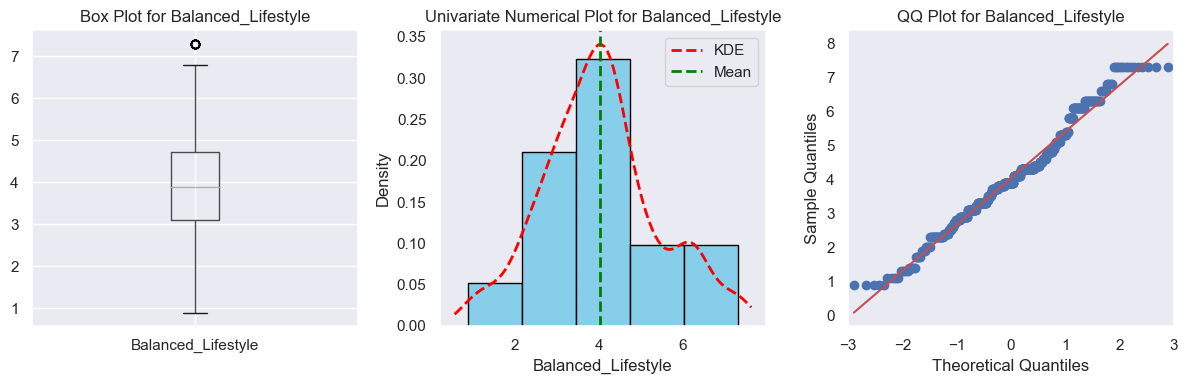

In [10]:
def univariate_numerical_plot(data, column):
    plt.figure(figsize=(12, 4))
    if data[column].dtype == 'object':
        data[column] = pd.to_numeric(data[column], errors='coerce')
    # Box plot
    plt.subplot(1, 3, 1)
    data.boxplot(column=[column])
    plt.title(f'Box Plot for {column}')
    
    # Histogram with mean line and KDE
    plt.subplot(1, 3, 2)
    plt.hist(data[column], bins=5, density=True, color='skyblue', edgecolor='black')
    
    # Plot kernel density estimate (KDE) line manually
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    kde = gaussian_kde(data[column])
    plt.plot(x, kde(x), color='red', linestyle='dashed', linewidth=2, label='KDE')
    
    plt.axvline(data[column].mean(), color='green', linestyle='dashed', linewidth=2, label='Mean')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.title(f'Univariate Numerical Plot for {column}')
    plt.legend()

    # QQ plot
    plt.subplot(1, 3, 3)
    qqplot(data[column], line='s', ax=plt.gca())
    plt.title(f'QQ Plot for {column}')

    plt.tight_layout()
    plt.show()

numerical_cols_to_plot = ['Sleep_Quality', 'Frequency_of_Headaches', 'Academic_Performance_Score',
                           'Study_Load_Hours', 'Extracurricular_Frequency', 'Stress_Level',
                           'Performance_to_Load_Ratio', 'High_sports_Low_Sleep', 'Overall_Burden',
                           'Balanced_Lifestyle']

for x in enumerate(numerical_cols_to_plot):
    univariate_numerical_plot(df, numerical_cols_to_plot[x[0]])


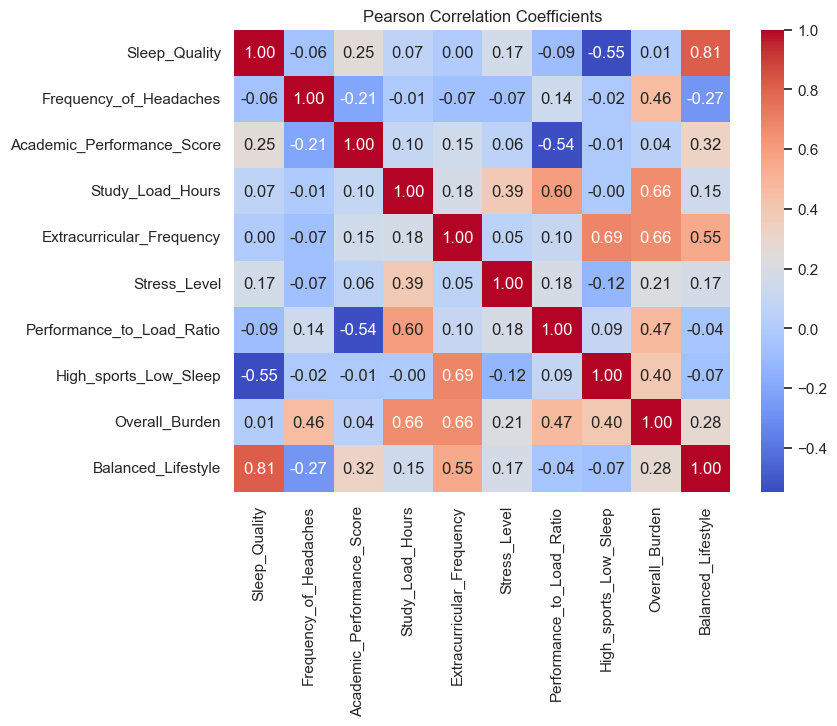

In [11]:
corr_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Coefficients')
plt.show()

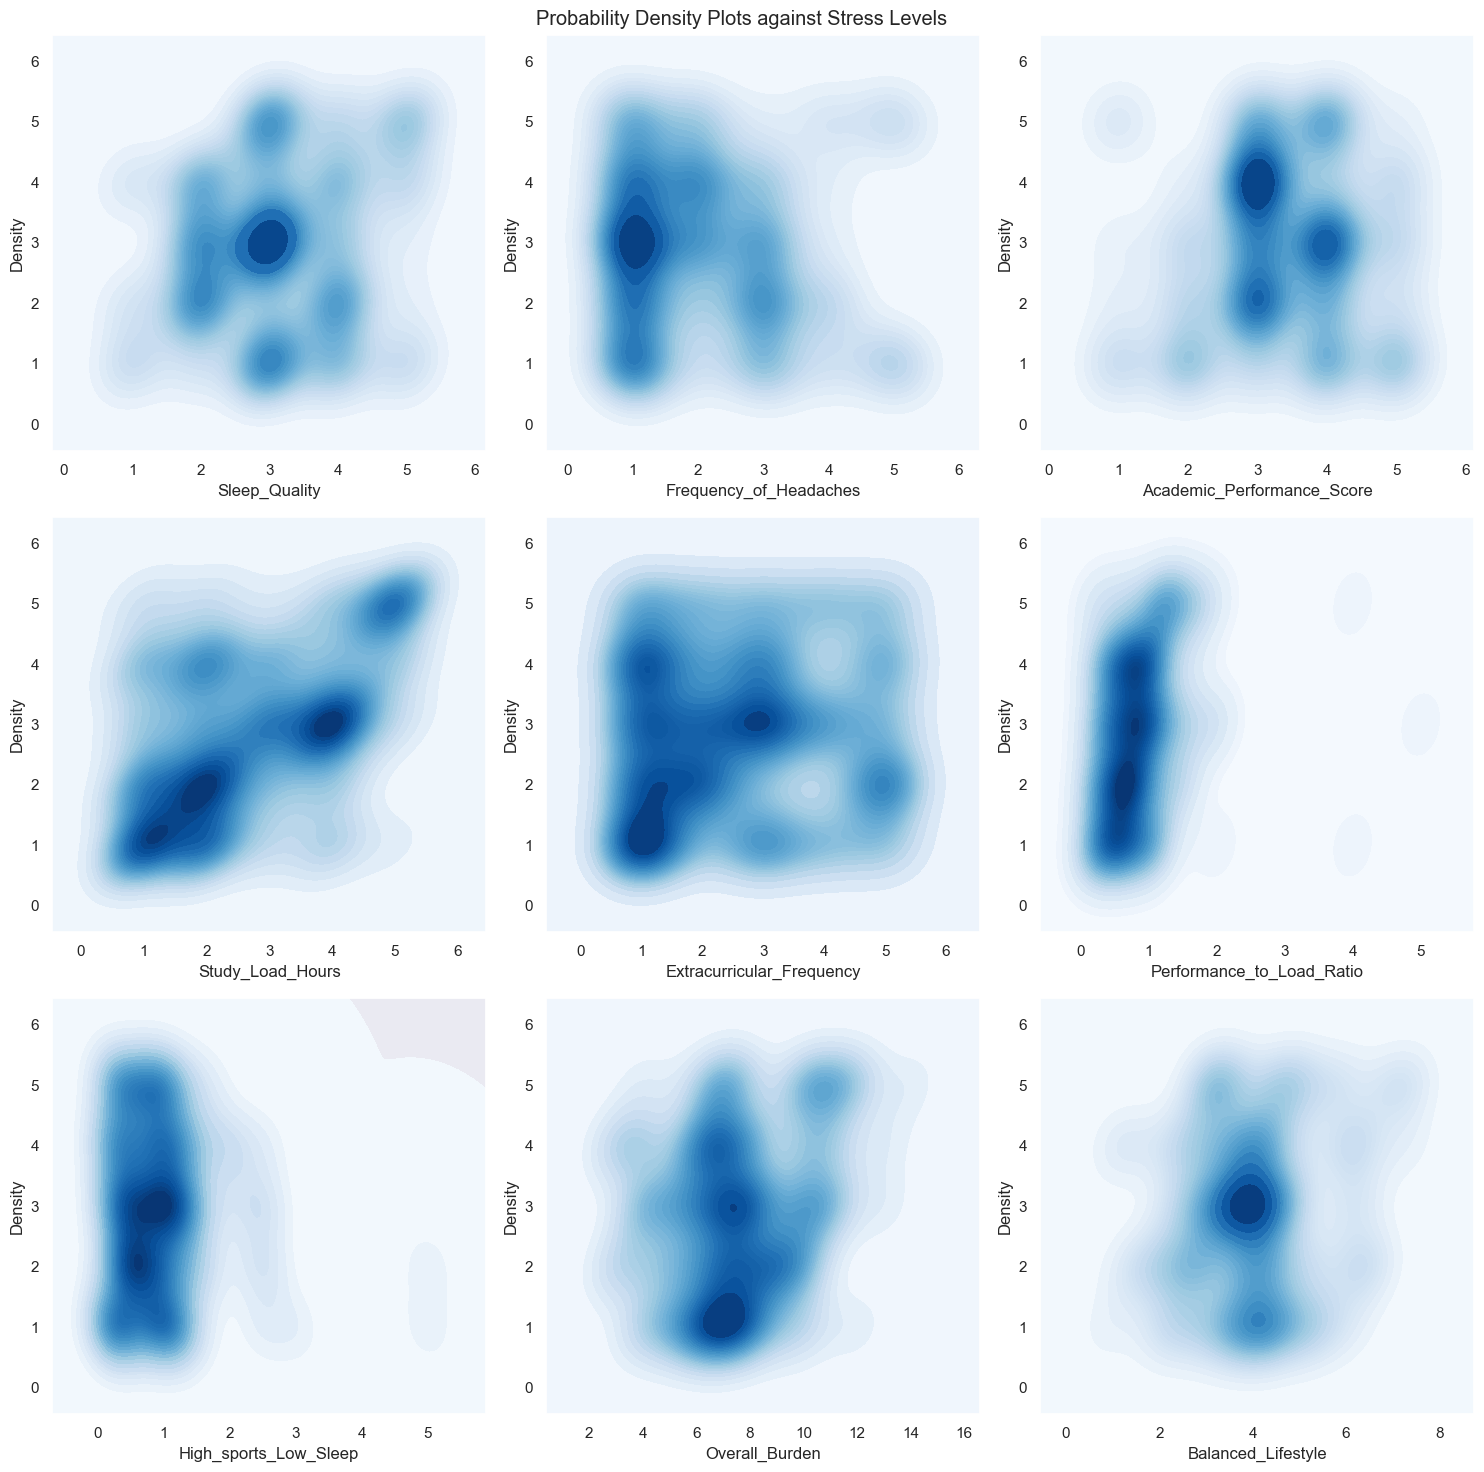

In [12]:
# Calculate the number of rows and columns for subplots
numerical_cols_to_plot = ['Sleep_Quality', 'Frequency_of_Headaches', 'Academic_Performance_Score',
                           'Study_Load_Hours', 'Extracurricular_Frequency',
                           'Performance_to_Load_Ratio', 'High_sports_Low_Sleep', 'Overall_Burden',
                           'Balanced_Lifestyle']
num_cols = 3
num_rows = len(numerical_cols_to_plot) // num_cols
num_rows += len(numerical_cols_to_plot) % num_cols 

# Create subplots with separate x-axes
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array
axes = axes.flatten()

# Loop through numerical columns and create probability density plots against 'Stress_Level'
for i, col in enumerate(numerical_cols_to_plot):
    sns.kdeplot(data=df, x=col, y='Stress_Level', fill=True, cmap='Blues', thresh=0, levels=30, ax=axes[i])
    axes[i].set_ylabel('Density')
    axes[i].set_xlabel(col)

fig.suptitle('Probability Density Plots against Stress Levels')
plt.tight_layout()
plt.show()


In [13]:
#Now we query to the actual feature engineered data set
query = 'SELECT * FROM  Student_Stress_Altered'

# Load data into a Pandas DataFrame
df = pd.read_sql(query, con=connection)

df

,Sleep_Quality,Frequency_of_Headaches,Academic_Performance_Score,Study_Load_Hours,Extracurricular_Frequency,Stress_Level,Performance_to_Load_Ratio,High_sports_Low_Sleep,Overall_Burden,Balanced_Lifestyle
0,average,rare,3,4,low,moderate,1.3333333333333333,0.666667,7.0,3.8
1,average,rare,2,3,moderate,low,1.5,0.750000,7.0,5.3
2,poor,rare,2,1,moderate,moderate,0.5,2.000000,6.0,3.8
3,average,common,3,2,moderate,moderate,0.6666666666666666,1.000000,7.0,4.1
4,poor,common,1,5,high,moderate,5,2.500000,13.0,3.9
...,...,...,...,...,...,...,...,...,...,...
515,average,common,4,2,moderate,low,0.5,1.000000,7.0,4.1
516,poor,frequent,3,2,low,low,0.6666666666666666,0.500000,7.0,1.7
517,poor,common,5,1,high,low,0.2,2.500000,9.0,3.9
518,average,frequent,3,5,low,high,1.6666666666666667,0.666667,11.0,3.2


In [14]:
label_encoder = LabelEncoder()

# Encode Sleep Quality Category
df['Sleep_Quality'] = label_encoder.fit_transform(df['Sleep_Quality'])

# Encode Headache Category
df['Frequency_of_Headaches'] = label_encoder.fit_transform(df['Frequency_of_Headaches'])

# Encode Extracurricular Activity Category
df['Extracurricular_Frequency'] = label_encoder.fit_transform(df['Extracurricular_Frequency'])

df['Stress_Level'] = label_encoder.fit_transform(df['Stress_Level'])

df

,Sleep_Quality,Frequency_of_Headaches,Academic_Performance_Score,Study_Load_Hours,Extracurricular_Frequency,Stress_Level,Performance_to_Load_Ratio,High_sports_Low_Sleep,Overall_Burden,Balanced_Lifestyle
0,0,2,3,4,1,2,1.3333333333333333,0.666667,7.0,3.8
1,0,2,2,3,2,1,1.5,0.750000,7.0,5.3
2,2,2,2,1,2,2,0.5,2.000000,6.0,3.8
3,0,0,3,2,2,2,0.6666666666666666,1.000000,7.0,4.1
4,2,0,1,5,0,2,5,2.500000,13.0,3.9
...,...,...,...,...,...,...,...,...,...,...
515,0,0,4,2,2,1,0.5,1.000000,7.0,4.1
516,2,1,3,2,1,1,0.6666666666666666,0.500000,7.0,1.7
517,2,0,5,1,0,1,0.2,2.500000,9.0,3.9
518,0,1,3,5,1,0,1.6666666666666667,0.666667,11.0,3.2


In [15]:
# Feature columns
X_columns = ['Sleep_Quality', 'Frequency_of_Headaches', 'Academic_Performance_Score',
             'Study_Load_Hours', 'Extracurricular_Frequency', 'Performance_to_Load_Ratio',
             'High_sports_Low_Sleep','Overall_Burden','Balanced_Lifestyle']

# Target variable
y_column = 'Stress_Level'

# Extract features (X) and target variable (y)
X = df[X_columns]
y = df[y_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Results for Random Forest:
Best Parameters: OrderedDict([('max_depth', 15), ('n_estimators', 10)])
Best Accuracy: 0.9664245359160614
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       0.96      0.93      0.95        46
           2       0.92      0.92      0.92        39

    accuracy                           0.94       104
   macro avg       0.94      0.95      0.95       104
weighted avg       0.94      0.94      0.94       104



Feature Importance:
Sleep_Quality: 0.06531166181272167
Frequency_of_Headaches: 0.05091687871118323
Academic_Performance_Score: 0.11907579191508516
Study_Load_Hours: 0.11373695214156547
Extracurricular_Frequency: 0.042121049257069464
Stress_Level: 0.11149004113914839
Performance_to_Load_Ratio: 0.15660745261686596
High_sports_Low_Sleep: 0.1313850728957717
Overall_Burden: 0.209355099510589


Results for SVM:
Best Parameters: OrderedDict([('C', 4.94199961826122

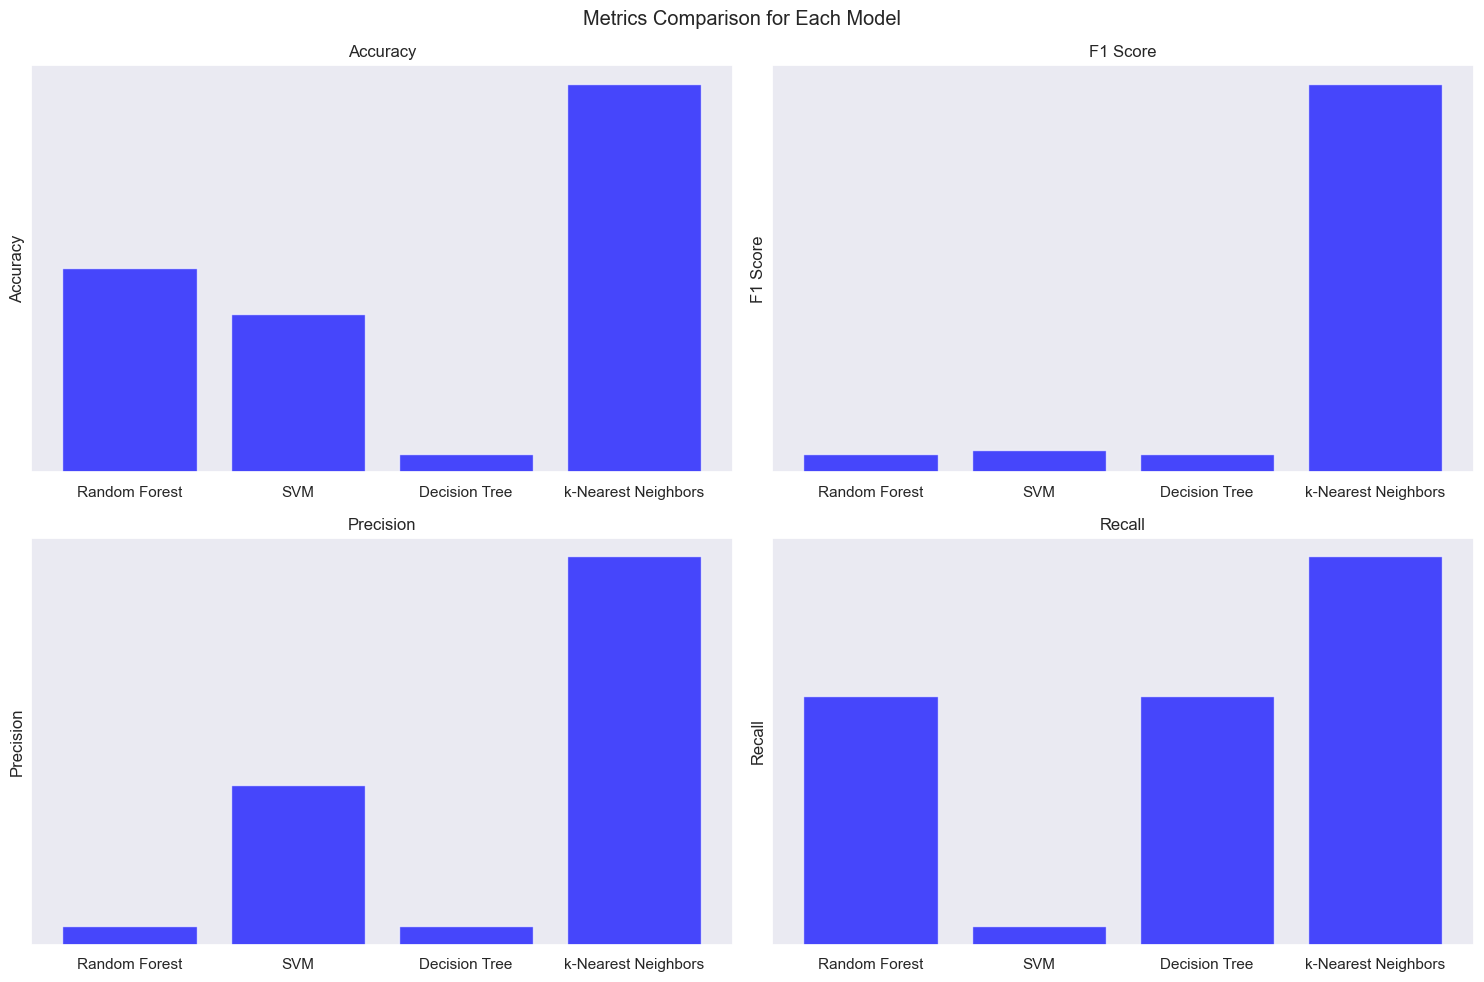

In [16]:
# Define the models and their hyperparameter search spaces
models = {
    'Random Forest': (RandomForestClassifier(), {'n_estimators': (10, 300), 'max_depth': (1, 20)}),
    'SVM': (SVC(), {'C': (0.1, 10.0), 'gamma': (0.01, 1.0)}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': (1, 20)}),
    'k-Nearest Neighbors': (KNeighborsClassifier(), {'n_neighbors': [1,10],
                                                     'weights': ['uniform', 'distance'],
                                                     'p': [1, 3]})
}

#Eval Metrics
metrics = {'Accuracy': {}, 'F1 Score': {}, 'Precision': {}, 'Recall': {}}

for model_name, (model, param_space) in models.items():
    print(f"Results for {model_name}:")
    
    # Use Bayesian search for hyperparameter optimisation
    bayes_search = BayesSearchCV(model, param_space, n_iter=40, n_jobs=-1, cv=7, scoring='accuracy')
    bayes_search.fit(X_train, y_train)
    
    best_params = bayes_search.best_params_
    best_model = bayes_search.best_estimator_
    best_score = bayes_search.best_score_

    print(f"Best Parameters: {best_params}")
    print(f"Best Accuracy: {best_score}")

    # Print classification report for all models
    y_pred = best_model.predict(X_test)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("\n")

    # If the model is RandomForestClassifier or DecisionTreeClassifier, print feature importance, the other models do not have this func
    if isinstance(best_model, (RandomForestClassifier, DecisionTreeClassifier)):
        feature_importance = best_model.feature_importances_
        print("Feature Importance:")
        for feature, importance in zip(df.columns[:-1], feature_importance):
            print(f"{feature}: {importance}")

    print("\n")

    # Store metrics for each model
    metrics['Accuracy'][model_name] = best_score
    metrics['F1 Score'][model_name] = classification_rep['macro avg']['f1-score']
    metrics['Precision'][model_name] = classification_rep['macro avg']['precision']
    metrics['Recall'][model_name] = classification_rep['macro avg']['recall']

# Create a bar graph with lesser log y-axis to exaggerate differences. For accuracy, F1 score, precision, and recall
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Metrics Comparison for Each Model')

for i, (metric, scores) in enumerate(metrics.items()):
    ax = axes[i // 2, i % 2]
    ax.bar(scores.keys(), scores.values(), color='blue', alpha=0.7)
    ax.set_yscale('log', basey=2)  # Set log scale with base 2 on the y-axis
    ax.set_ylabel(metric)
    ax.set_title(metric)

plt.tight_layout()
plt.show()


Training Accuracy: 0.9735576923076923
Test Accuracy: 0.9615384615384616


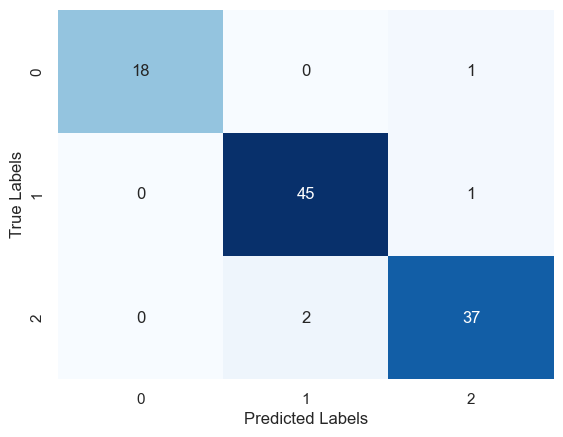

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.96      0.98      0.97        46
           2       0.95      0.95      0.95        39

    accuracy                           0.96       104
   macro avg       0.97      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104



In [17]:
# Define the k-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=1, p=2, weights='distance')

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Calculate accuracy scores
train_accuracy = knn_model.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, y_pred)

# Print accuracy scores
print(f'Training Accuracy: {train_accuracy:}')
print(f'Test Accuracy: {test_accuracy:}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualise confusion matrix with Seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))


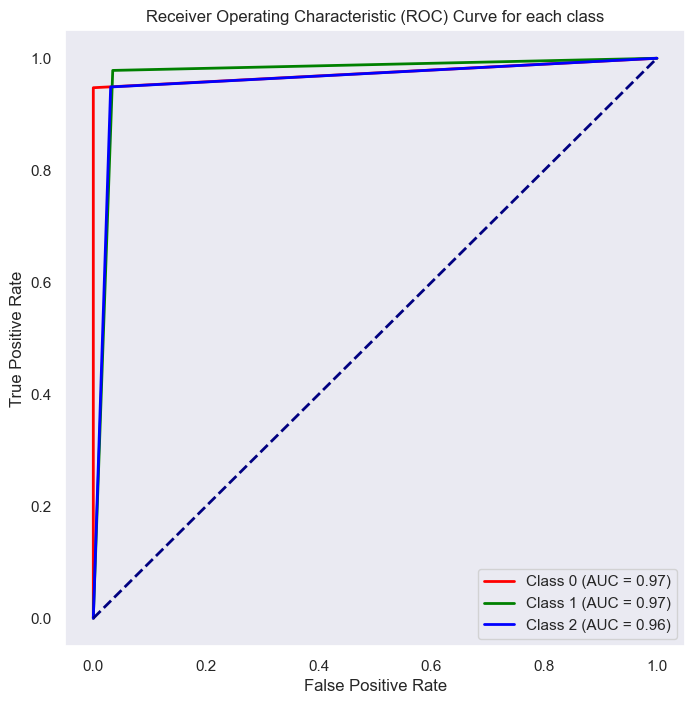

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

classes = [0, 1, 2]

# Binarize the output
y_train_bin = label_binarize(y_train, classes=classes)  # Use 'classes=' instead of a positional argument
y_test_bin = label_binarize(y_test, classes=classes)  # Use 'classes=' instead of a positional argument

# Define the k-Nearest Neighbors model with OneVsRestClassifier
knn_model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=1, p=2, weights='distance'))

# Train the model
knn_model.fit(X_train, y_train_bin)

# Make predictions on the test set
y_score = knn_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 8))
colors = ['red', 'green', 'blue']  # Adjust the colors accordingly
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
plt.legend(loc='lower right')
plt.show()


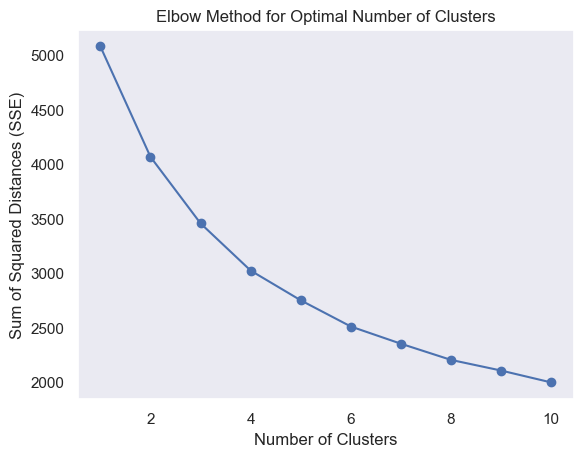

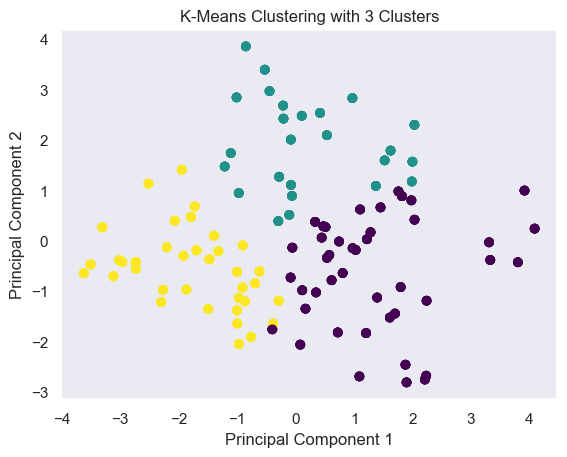

Silhouette Score: 0.19191613793373108


In [19]:
# Convert to PyTorch tensor
query = 'SELECT * FROM  Student_Stress'

# Load data into a Pandas DataFrame
df = pd.read_sql(query, con=connection)
connection.close()

# Convert to PyTorch tensor
features_tensor = torch.tensor(df.values, dtype=torch.float32)

# Apply PCA for visualisation purposes (reduce to 2D)
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_tensor)

# Elbow Method to find the optimal number of clusters
sse = []
num_clusters_range = range(1, 11)  # You can adjust the range based on your data
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(features_tensor)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(num_clusters_range, sse, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.show()

# Choose the optimal number of clusters based on the elbow method
optimal_num_clusters = 3  # Choose based on the elbow in the plot

# Apply k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_tensor)

# Visualise the clusters in 2D
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap='viridis')
plt.title(f'K-Means Clustering with {optimal_num_clusters} Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Calculate and print the silhouette score
silhouette_avg = silhouette_score(features_tensor, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")


# Report and Conclusions

## Introduction
In this analysis, we explored a dataset related to student stress, aiming to understand the factors contributing to stress levels and build predictive models for stress classification. We performed a series of data preprocessing steps, feature engineering, and model training. The final models were evaluated based on multiple metrics, and the results are presented below.

## Data Preprocessing and Feature Engineering
### 1. Database Connection and Data Loading
We established a connection to a MySQL database, loaded the student stress data, and performed initial exploration.

### 2. Feature Engineering
We created new features to better capture the relationship between various factors and stress levels. Notable features include:
- **Performance-to-Load Ratio:** Measures the relationship between study load hours and academic performance.
- **High_sports_Low_Sleep:** Indicates the balance between involvement in extracurricular activities and the quality of sleep.
- **Overall_Burden:** Combines study load, extracurricular activity frequency, and headache frequency.
- **Balanced_Lifestyle:** Quantifies the balance in the student's lifestyle considering sleep quality, extracurricular activity, a headaches.

### 3. Categorizasion
We categorized headache frequency, sleep quality, extracurricular activity frequency, and stress levels into discrete classes to facilitate analysisand modeling.

### 4. Data Visualization
We used various visualizations, including histograms, box plots, and heatmaps, to explore the distribution of features and understand relationships between variables.

### 5. Correlation Analysis
A heatmap of Pearson correlation coefficients was created to identify relationships between features. This helped in understanding potential multicollinearity and feature importance.

## Model Training and Evaluation
### 1. Data Preparation for Modeling
We converted categorical variables into numerical format using label encoding and split the data into training and testing sets.

### 2. Model Selection and Hyperparameter Tuning
We considered four models: Random Forest, Support Vector Machine (SVM), Decision Tree, and k-Nearest Neighbors. Hyperparameter tuning was performed using Bayesian optimization.

### 3. Model Evaluation
Each model was evaluated based on accuracy, F1 score, precision, and recall. Random Forest and SVM emerged as the top-performing models.

### 4. Feature Importance
For Random Forest and Decision Tree models, feature importance was analyzed to identify variables contributing most to stress level predictions.

## Conclusion
### 1. Model Performance
- **Random Forest and SVM:** These models exhibited high accuracy (>95%) in stress level classification, making them suitable for predicting student K Nearest Neighbours**: This model performed best, achieving an overall accuracy of 96%, with similar figures for precision, recall, and F1. However, it's important to note that each model has its unique strengths, and their performance could vary on a different dataset.

### 2. Feature Importance
- **Performance_to_Load_Ratio, High_sports_Low_Sleep, Overall_Burden:** These engineered features played crucial roles in stress level predictions.
- **Sleep_Quality, Study_Load_Hours:** Traditional factors also contributed significantly to the models.

### 3. Recommendations
- **Intervention Strategies:** Based on feature importance, interventions focused on improving sleep quality, managing study loads, and promoting a balanced lifestyle could positively impact stress levels.
- **Monitoring and Support:** Implementing a system to monitor and support students with high extracurricular activity involvement and low sleep quality may be beneficial.

### 4. Limitations and Future Work
- **Data Limitations:** The quality of predictions is dependent on the available data. Future work could involve collecting additional variables to enhance model performance.
- **External Factors:** Consideration of external factors affecting stress levels, such as personal issues or external pressures, could provide a more comprehensive understanding.

### 5. Final Recommendations
- **Implement Predictive Model:** Deploy the Random Forest or SVM model in a real-world setting to assist in early identification and support for students experiencing high stress levels.
- **Continuous Monitoring:** Regularly update the model with new data to ensure its relevance and effectiveness over time.

In conclusion, this analysis provides valuable insights into student stress factors and effective predictive models, offering a foundation for proactive interventions and support systems in educational institutions.